In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [416]:
train = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/train.csv")
meal_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/meal_info.csv")
fulfilment_center_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/fulfilment_center_info.csv")
test = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/test.csv")

merge1 = pd.merge(train, fulfilment_center_info, how='left')
merge2 = pd.merge(merge1, meal_info, how='left')

merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']] = merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']].astype('object')

df_weekly_orders = merge2.groupby(['week'])['num_orders'].sum().reset_index()
df_weekly_orders.set_index(df_weekly_orders['week'], inplace=True)
df_weekly_orders.drop(columns='week', inplace=True)

In [417]:
train_orders  = df_weekly_orders [:110]
val_orders = df_weekly_orders[110:]
train_orders.shape, val_orders.shape

((110, 1), (35, 1))

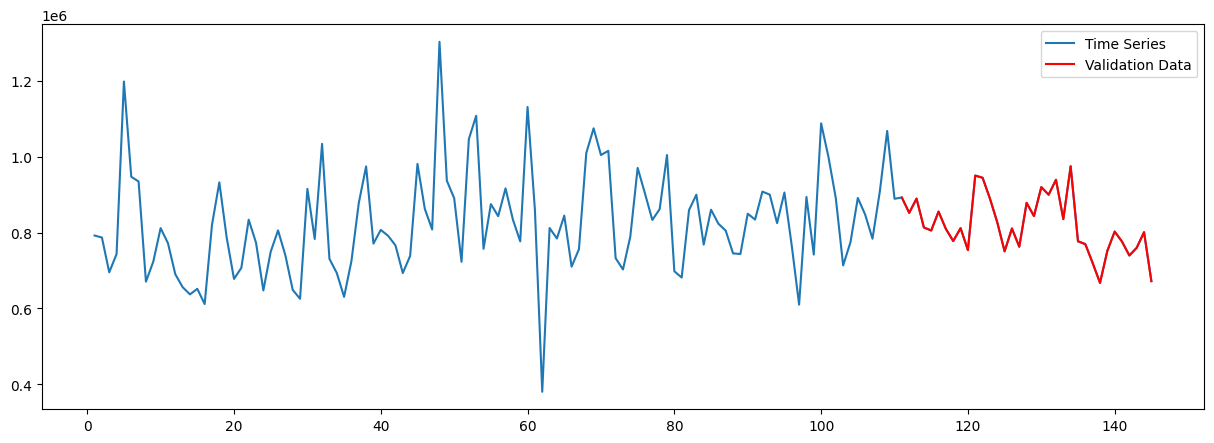

In [418]:
plt.figure(figsize=(15,5))
plt.plot(df_weekly_orders['num_orders'], label = 'Time Series')
plt.plot(val_orders, color='red', label='Validation Data')
plt.legend()
plt.show()

In [419]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [420]:
''' Scale the data - (0, 1)'''
scaler = MinMaxScaler(feature_range=(0, 1))

train_orders = scaler.fit_transform(train_orders)
val_orders  = scaler.fit_transform(val_orders)

In [421]:
#shape of the datasets
print(f'Shape of Training set: {train_orders.shape}')
print(f'Shape of Validation set : {val_orders.shape}')

Shape of Training set: (110, 1)
Shape of Validation set : (35, 1)


In [422]:
'''Let's Create Dataset for LSTM model, i.e. converting time series into inputs and labele'''
def create_dataset(df, lookback):
    X_data, y_data = [], []

    for i in range(lookback, len(df)):
        X_data.append(df[i-lookback:i, 0])
        y_data.append(df[i,0])

    return np.array(X_data), np.array(y_data)

lookback = 25
X_train, y_train = create_dataset(train_orders, lookback)
X_val, y_val = create_dataset(val_orders, lookback)


In [423]:
print("Shape of train input: " + str(X_train.shape))
print("Shape of train labels: " + str(y_train.shape))
print("Shape of Validation input: " + str(X_val.shape))
print("Shape of Validation labels: " + str(y_val.shape))

Shape of train input: (85, 25)
Shape of train labels: (85,)
Shape of Validation input: (10, 25)
Shape of Validation labels: (10,)


In [424]:
'''Reshaping the data to tensorflow can understand'''

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

print("Shape of train input: " + str(X_train.shape))
print("Shape of train labels: " + str(y_train.shape))
print("Shape of test input: " + str(X_val.shape))
print("Shape of test labels: " + str(y_val.shape))

Shape of train input: (85, 1, 25)
Shape of train labels: (85,)
Shape of test input: (10, 1, 25)
Shape of test labels: (10,)


In [425]:
'''Creating LSTM Model using keras'''

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape = (1, lookback)))
# model.add(LSTM(50, activation='relu'))
# model.add(LSTM(32, input_shape = (1, lookback)))
# model.add(Dense(8,'relu'))
model.add(Dense(1, 'linear'))
model.compile(loss = 'mse', optimizer='adam')

In [426]:
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,105 (90.25 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 0 (0.00 B)

In [427]:
model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.1075 
Epoch 2/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.0167
Epoch 3/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.0215
Epoch 4/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0196
Epoch 5/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0206  
Epoch 6/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.0153
Epoch 7/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0217  
Epoch 8/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0129
Epoch 9/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0229
Epoch 10/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0219
Epoch 11/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0189
Epoch 12/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.0162
Epoch 13/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0232  
Epoch 14/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 0.0234
Epoch 15/300
85/85 ━━━━━━━━━━━━━━━━━

In [428]:
X_val

array([[[0.7320987 , 0.6004114 , 0.72256108, 0.47528182, 0.44885597,
         0.6113236 , 0.46236136, 0.35864023, 0.46913356, 0.28118247,
         0.92015052, 0.90132227, 0.7233085 , 0.51965853, 0.27036126,
         0.46630314, 0.30999353, 0.68584371, 0.57296517, 0.82109908,
         0.75589236, 0.88399533, 0.5467148 , 1.        , 0.35668722]],

       [[0.6004114 , 0.72256108, 0.47528182, 0.44885597, 0.6113236 ,
         0.46236136, 0.35864023, 0.46913356, 0.28118247, 0.92015052,
         0.90132227, 0.7233085 , 0.51965853, 0.27036126, 0.46630314,
         0.30999353, 0.68584371, 0.57296517, 0.82109908, 0.75589236,
         0.88399533, 0.5467148 , 1.        , 0.35668722, 0.33237036]],

       [[0.72256108, 0.47528182, 0.44885597, 0.6113236 , 0.46236136,
         0.35864023, 0.46913356, 0.28118247, 0.92015052, 0.90132227,
         0.7233085 , 0.51965853, 0.27036126, 0.46630314, 0.30999353,
         0.68584371, 0.57296517, 0.82109908, 0.75589236, 0.88399533,
         0.5467148 , 1.     

In [429]:
X_val.shape

(10, 1, 25)

In [430]:
'''Lets predict now'''

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [431]:
y_val.shape

(10,)

In [432]:
'''Inverse Transforming the data'''
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])

test_pred = scaler.inverse_transform(val_pred)
y_val = scaler.inverse_transform([y_val])

In [406]:
y_train[0]

array([809224.82750121, 787299.36286756, 756922.44160443, 749107.84355615,
       845748.05060256, 801696.16595877, 885340.25888139, 784274.03466242,
       771832.4640651 , 750788.80362078, 782250.81726504, 833235.49576778,
       865466.0054289 , 797613.73915628, 809676.06063514, 804455.21995859,
       796055.75178472, 771721.82196727, 786822.46876516, 867676.51457019,
       828158.95638147, 810045.97849234, 975072.        , 852940.12022088,
       837542.87261856, 781641.28594898, 889542.32578363, 910012.78017895,
       793049.41936144, 832333.02949993, 821703.72314358, 846188.6194379 ,
       818769.37473576, 799552.30868364, 917752.06161847, 827320.80916447,
       667343.        , 811314.36350542, 802127.40353284, 822243.27000017,
       777324.57783693, 792720.49240193, 877266.0518144 , 898999.22581417,
       875491.44587781, 879182.95948525, 784812.24848168, 774856.79249225,
       803821.36071138, 864197.62041581, 841591.97348797, 818419.11917907,
       827962.33337629, 8

In [433]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
val_score = np.sqrt(mean_squared_error(y_val[0], val_pred[:,0]))
print('Test Score: %.2f RMSE' % (val_score))

Train Score: 8581.98 RMSE
Test Score: 747391.19 RMSE


In [434]:
X_train.shape, X_val.shape, y_train[0].shape, train_pred[:,0].shape, y_val[0].shape, val_pred[:,0].shape

((85, 1, 25), (10, 1, 25), (85,), (85,), (10,), (10,))

In [435]:
week_train = list(range(1, len(X_train)+1))
week_train

trainActual = pd.DataFrame({'Number of Orders':y_train[0]})
trainActual.index = week_train

trainPred = pd.DataFrame({'Number of Orders': train_pred[:,0]})
trainPred.index = week_train

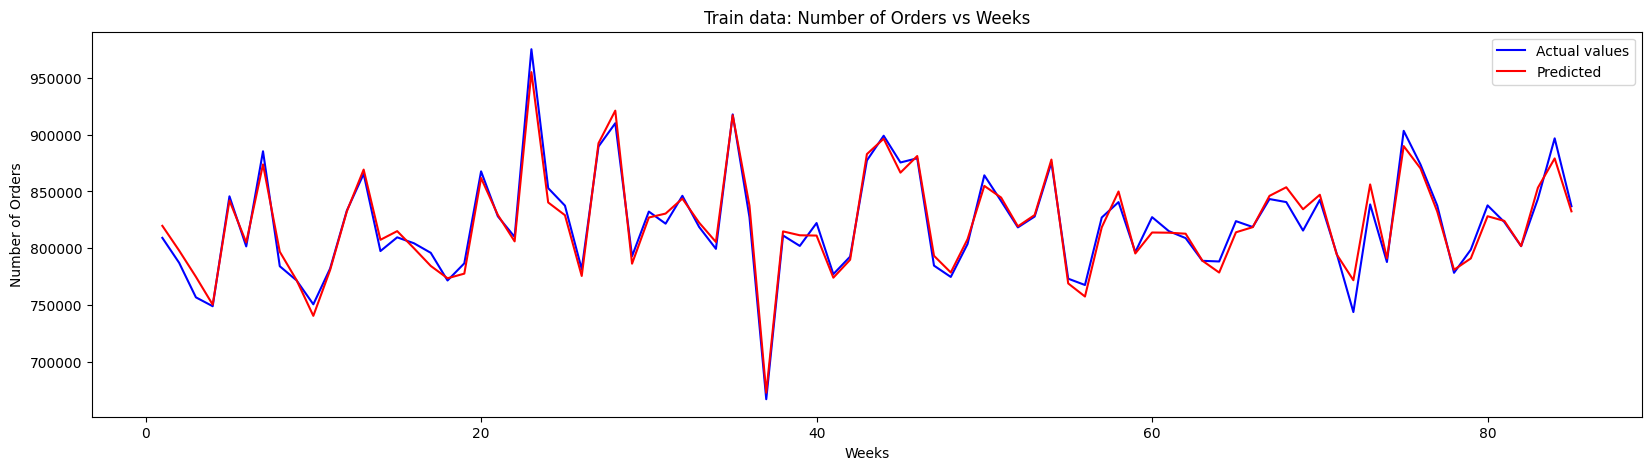

In [436]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()

In [437]:
week_val = list(range(len(X_train)+1, len(X_train)+len(X_val)+1))
week_val

[86, 87, 88, 89, 90, 91, 92, 93, 94, 95]

In [438]:
valActual = pd.DataFrame({'Number of Orders': y_val[0]})
valActual.index = week_val

valPred = pd.DataFrame({'Number of Orders': test_pred[:,0]})
valPred.index = week_val

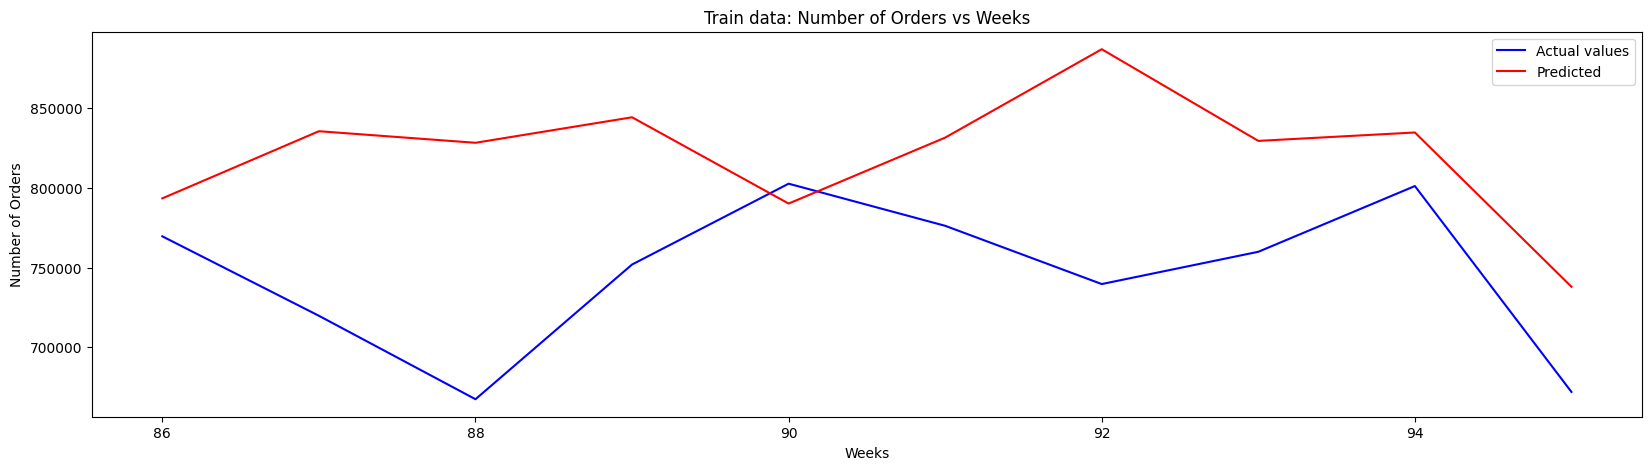

In [439]:
plt.figure(figsize=(20,5))
plt.plot(valActual, color='blue', label='Actual values')
plt.plot(valPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()

In [440]:
valPred

,Number of Orders
86,793472.7500
87,835634.8125
88,828373.5000
89,844385.1875
90,790205.5000
91,831622.2500
92,887123.1250
93,829559.9375
94,834840.9375
95,737964.0000
